**Task 4 Hand Gesture Dataset**

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'leapgestrecog:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F39466%2F61155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240803%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240803T130258Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D75554b0036d0ec77f590f1ac0a6c7ed9d936a2c359b6aa8aa7f121634aa8fbda8325b649b36bf90e0016b32b4fa79c4b15998aa1243ca67bd4cbc2e4fe8bfc7caeaf19c97173be1c06439da57c5bf59913491f267b1b72ba2056fdf7b8fb1c7b84b02ae19bfa73597c08cceca1f75670f0a69f381d5a0f768663b1690d5bb1af9dbd8df7e5f6b6a6d7a3bdb1c59ff7158e9beb42904c06ec5d5ca73681a50c34e6c64c6d26b879959fa181de497513aa22f2cc6685a0d19633853c3fdc56fcf74cb00f87135781af34d57fe23552262b71b2004e8883792cad9bb029b2cc8cd8e0bad7e026c5a7f5c9e494fd7704f99231ea1b05a83068a4e6ebf4b911227e32'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 2286085038 bytes downloaded
Downloaded and uncompressed: leapgestrecog
Data source import complete.


In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!unzip /content/leapgestrecog.zip
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download gti-upm/leapgestrecog

mv: cannot stat 'kaggle.json': No such file or directory
unzip:  cannot find or open /content/leapgestrecog.zip, /content/leapgestrecog.zip.zip or /content/leapgestrecog.zip.ZIP.
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.13G/2.13G [01:18<00:00, 30.1MB/s]
100% 2.13G/2.13G [01:18<00:00, 29.0MB/s]


In [19]:
import numpy as np
import pandas as pd
import os
import cv2

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [10]:
dir = '/content/leapGestRecog'
parent_dir = '/content'
print(os.listdir(parent_dir))

['.config', 'leapgestrecog.zip', 'sample_data']


In [12]:
import zipfile
import os

# Paths
zip_path = '/content/leapgestrecog.zip'
extract_dir = '/content/leapGestRecog'

# Create the directory if it does not exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Dataset extracted to:", extract_dir)


Dataset extracted to: /content/leapGestRecog


In [15]:
images = np.array(zip_path)
labels = np.array(extract_dir)
labels

array('/content/leapGestRecog', dtype='<U22')

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define parameters
img_height, img_width = 150, 150  # Adjust as needed
batch_size = 32

# Create ImageDataGenerator instances
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training and validation data
train_gen = datagen.flow_from_directory(
    directory=extract_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    directory=extract_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Extract labels
class_names = train_gen.class_indices
num_classes = len(class_names)


Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1947s 2s/step - accuracy: 0.4986 - loss: 0.7098 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2008s 2s/step - accuracy: 0.4983 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1942s 2s/step - accuracy: 0.4973 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1941s 2s/step - accuracy: 0.5098 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
  69/1000 ━━━━━━━━━━━━━━━━━━━━ 27:58 2s/step - accuracy: 0.4847 - loss: 0.6933

KeyboardInterrupt: 

250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 512ms/step


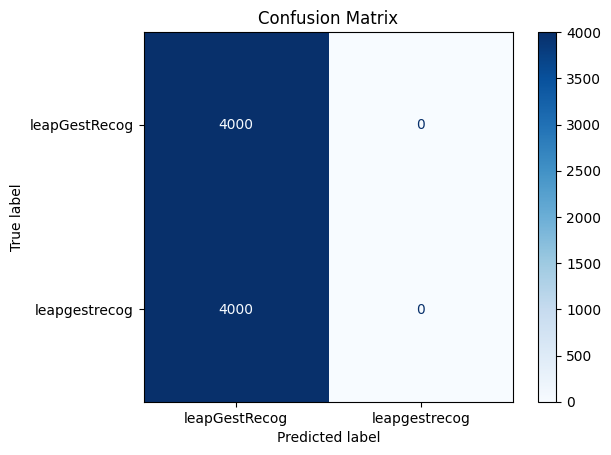

In [20]:
# Make predictions on the validation set
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_gen.class_indices.keys())

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Heat map')
plt.show()

In [24]:
from sklearn.metrics import classification_report
# Compute classification report
report = classification_report(y_true, y_pred_classes, target_names=train_gen.class_indices.keys(), output_dict=True)

# Extract F1 scores from the report
f1_scores = {class_name: metrics['f1-score'] for class_name, metrics in report.items() if class_name != 'accuracy'}
print("F1 Scores:\n", f1_scores)

F1 Scores:
 {'leapGestRecog': 0.6666666666666666, 'leapgestrecog': 0.0, 'macro avg': 0.3333333333333333, 'weighted avg': 0.3333333333333333}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 567ms/step


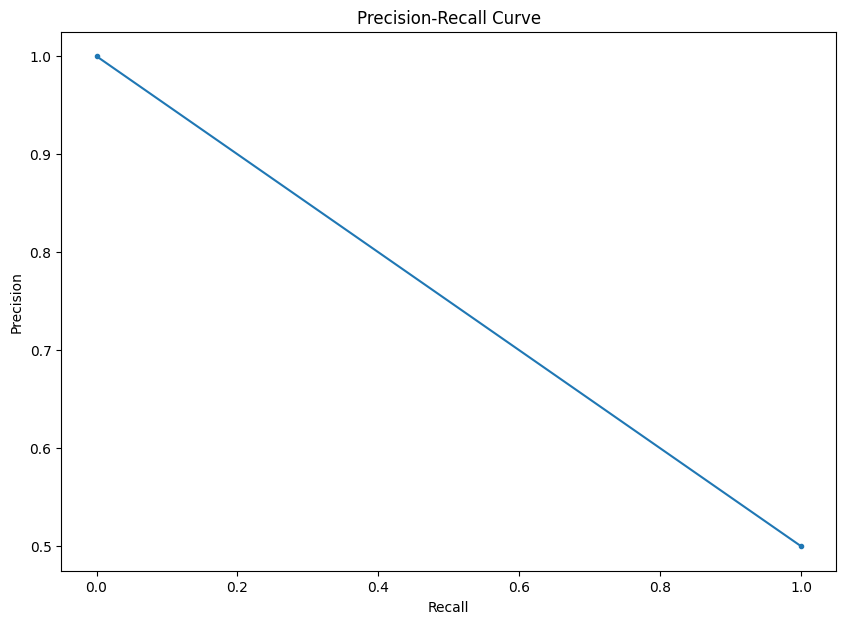

In [28]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multi-class
y_true_bin = label_binarize(y_true, classes=list(train_gen.class_indices.values()))
y_pred_bin = model.predict(val_gen)
y_pred_bin = np.argmax(y_pred_bin, axis=1)
y_pred_bin = label_binarize(y_pred_bin, classes=list(train_gen.class_indices.values()))

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_bin.ravel())

# Plot precision-recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


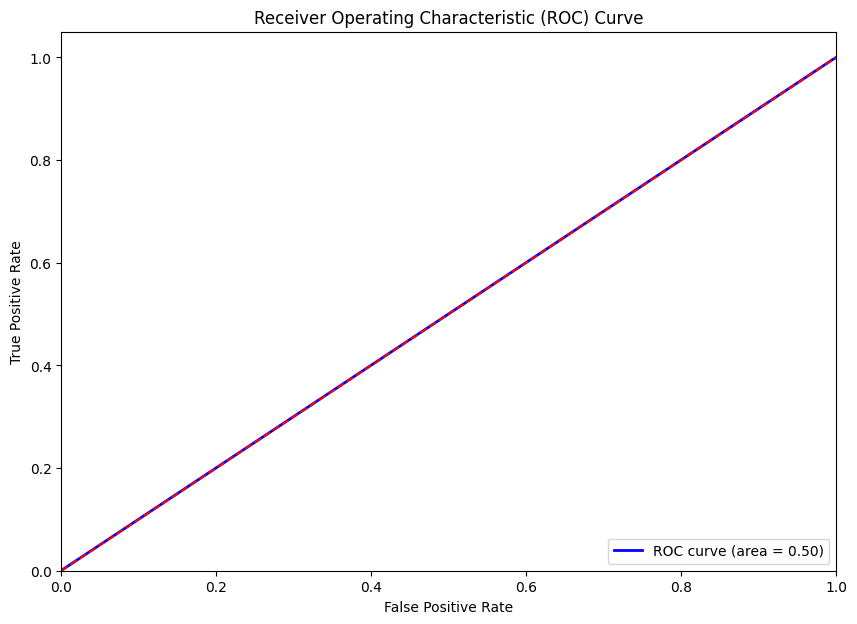

In [29]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [25]:
report_df = pd.DataFrame(report).transpose()

# Display the DataFrame
print("Classification Report Table:\n")
print(report_df)

Classification Report Table:

               precision  recall  f1-score  support
leapGestRecog       0.50     1.0  0.666667   4000.0
leapgestrecog       0.00     0.0  0.000000   4000.0
accuracy            0.50     0.5  0.500000      0.5
macro avg           0.25     0.5  0.333333   8000.0
weighted avg        0.25     0.5  0.333333   8000.0
